In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import itertools
import sklearn
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

Load data

In [ ]:
data = np.load('/content/drive/MyDrive/SC Lab/Dataset/data.npy',mmap_mode='r')
labels = np.load('/content/drive/MyDrive/SC Lab/Dataset/labels.npy',mmap_mode='r')

In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (10015, 224, 224, 3)
Labels shape: (10015, 7)


Loading Images from the data

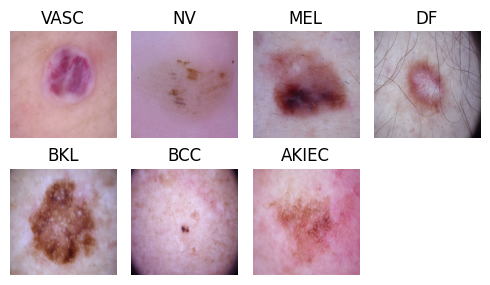

In [ ]:
# Get unique class labels and their corresponding indices in the data array
unique_classes = np.unique(labels, axis=1)

# Create a dictionary to store one data sample from each class
class_samples = {}

# Map class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# Select one data sample from each class
for class_label in unique_classes:
    class_indices = np.where(np.all(labels == class_label, axis=1))[0]
    class_samples[tuple(class_label)] = data[class_indices[0]]

# Plot the images in 2 rows
plt.figure(figsize=(5, 3))
for i, (class_label, image_data) in enumerate(class_samples.items()):
    class_index = np.argmax(class_label)  # Get the index of the class
    class_name = class_names[class_index]  # Get the corresponding class name
    plt.subplot(2, 4, i + 1)
    plt.imshow(image_data)
    plt.title(f'{class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Frequency of the data

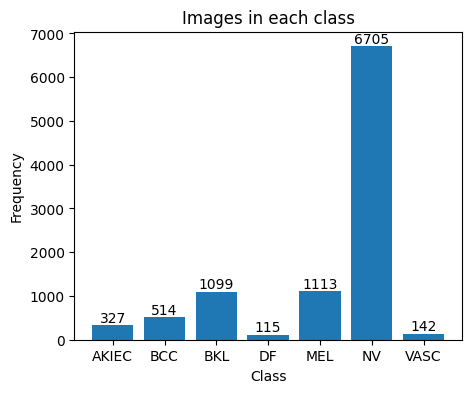

In [ ]:
# Sum the one-hot encoded labels along the rows to get the frequency of each class
class_counts = np.sum(labels, axis=0)

# Map class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# Plot the class frequencies
plt.figure(figsize=(5, 4))
plt.bar([class_names[class_idx] for class_idx in range(len(class_names))], class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in each class')

# Annotate the bars with the class frequencies (integer format)
for i, count in enumerate(class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

Split Data

In [ ]:
# Split the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1,stratify=labels, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1,stratify=train_labels, random_state=42)

Augmentation

In [ ]:
# Create an ImageDataGenerator for data augmentation during training (optional)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

Callbacks

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 5,mode='max', min_lr = 1e-4,verbose = 1)
#early_stop = EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
saved_model = '/content/drive/MyDrive/SC Lab/Saved Model/InceptionResNetV2.h5'
model_chkpt = ModelCheckpoint(saved_model ,save_best_only = True, monitor = 'val_accuracy',verbose = 1)

# callback_list = [early_stop, model_chkpt, lr_reduce]
callback_list = [model_chkpt, lr_reduce]

InceptionResNetV2 Model

In [ ]:
base_model = InceptionResNetV2(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))

219055592/219055592 [==============================] - 10s 0us/step


In [ ]:
# Add custom classification layers on top of InceptionResNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Create the final model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)



# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model Training

In [ ]:
epochs = 30
batch_size = 16

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/30
507/507 [==============================] - ETA: 0s - loss: 0.9252 - accuracy: 0.6775
Epoch 1: val_accuracy improved from -inf to 0.62084, saving model to /content/drive/MyDrive/SC Lab/Saved Model/irnv2.h5
507/507 [==============================] - 271s 471ms/step - loss: 0.9252 - accuracy: 0.6775 - val_loss: 0.9583 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 2/30
507/507 [==============================] - ETA: 0s - loss: 0.8627 - accuracy: 0.6958
Epoch 2: val_accuracy improved from 0.62084 to 0.66851, saving model to /content/drive/MyDrive/SC Lab/Saved Model/irnv2.h5
507/507 [==============================] - 234s 461ms/step - loss: 0.8627 - accuracy: 0.6958 - val_loss: 1.1028 - val_accuracy: 0.6685 - lr: 0.0010
Epoch 3/30
507/507 [==============================] - ETA: 0s - loss: 0.8543 - accuracy: 0.6999
Epoch 3: val_accuracy improved from 0.66851 to 0.73392, saving model to /content/drive/MyDrive/SC Lab/Saved Model/irnv2.h5
507/507 [==============================] - 269s 53

In [ ]:
model= load_model('/content/drive/MyDrive/SC Lab/Saved Model/irnv2.h5')

In [ ]:
epochs = 20
batch_size = 16

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/20
507/507 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.8364
Epoch 1: val_accuracy improved from -inf to 0.81264, saving model to /content/drive/MyDrive/SC Lab/Saved Model/irnv2.h5
507/507 [==============================] - 230s 402ms/step - loss: 0.4504 - accuracy: 0.8364 - val_loss: 0.5414 - val_accuracy: 0.8126 - lr: 0.0010
Epoch 2/20
507/507 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.8366
Epoch 2: val_accuracy did not improve from 0.81264
507/507 [==============================] - 176s 347ms/step - loss: 0.4483 - accuracy: 0.8366 - val_loss: 0.5928 - val_accuracy: 0.8004 - lr: 0.0010
Epoch 3/20
507/507 [==============================] - ETA: 0s - loss: 0.4322 - accuracy: 0.8443
Epoch 3: val_accuracy did not improve from 0.81264
507/507 [==============================] - 174s 343ms/step - loss: 0.4322 - accuracy: 0.8443 - val_loss: 0.5310 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 4/20
507/507 [==========================

In [ ]:
model= load_model('/content/drive/MyDrive/SC Lab/Saved Model/irnv2.h5')

In [ ]:
epochs = 10
batch_size = 16

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/10
507/507 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9163
Epoch 1: val_accuracy improved from -inf to 0.85366, saving model to /content/drive/MyDrive/4.2/SC Lab/Project/Saved Model/irnv2.h5
507/507 [==============================] - 201s 360ms/step - loss: 0.2349 - accuracy: 0.9163 - val_loss: 0.4985 - val_accuracy: 0.8537 - lr: 5.0000e-04
Epoch 2/10
507/507 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9181
Epoch 2: val_accuracy did not improve from 0.85366
507/507 [==============================] - 173s 341ms/step - loss: 0.2259 - accuracy: 0.9181 - val_loss: 0.5481 - val_accuracy: 0.8492 - lr: 5.0000e-04
Epoch 3/10
507/507 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9199
Epoch 3: val_accuracy improved from 0.85366 to 0.85698, saving model to /content/drive/MyDrive/4.2/SC Lab/Project/Saved Model/irnv2.h5
507/507 [==============================] - 190s 374ms/step - loss: 0.2276 - accuracy: 0.91

In [ ]:
model= load_model('/content/drive/MyDrive/SC Lab/Saved Model/InceptionResNetV2.h5')

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=15,
                    callbacks=callback_list)

Epoch 1/15
507/507 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9351
Epoch 1: val_accuracy improved from -inf to 0.86807, saving model to /content/drive/MyDrive/4.2/SC Lab/Project/Saved Model/irnv2.h5
507/507 [==============================] - 219s 380ms/step - loss: 0.1767 - accuracy: 0.9351 - val_loss: 0.4719 - val_accuracy: 0.8681 - lr: 5.0000e-04
Epoch 2/15
507/507 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9416
Epoch 2: val_accuracy did not improve from 0.86807
507/507 [==============================] - 172s 338ms/step - loss: 0.1686 - accuracy: 0.9416 - val_loss: 0.6097 - val_accuracy: 0.8592 - lr: 5.0000e-04
Epoch 3/15
507/507 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.9444
Epoch 3: val_accuracy did not improve from 0.86807
507/507 [==============================] - 173s 342ms/step - loss: 0.1610 - accuracy: 0.9444 - val_loss: 0.5116 - val_accuracy: 0.8614 - lr: 5.0000e-04
Epoch 4/15
507/507 [==

In [ ]:
model= load_model('/content/drive/MyDrive/SC Lab/Saved Model/InceptionResNetV2.h5')

Test Accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

32/32 [==============================] - 10s 210ms/step - loss: 0.6894 - accuracy: 0.8573
Test Accuracy: 0.8572854399681091


Classification Report

In [ ]:
# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions and true labels to integer format
predicted_labels = np.argmax(predictions, axis=1)
# test_labels = test_data.classes
true_labels = np.argmax(test_labels, axis=1)

# Calculate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(report)

32/32 [==============================] - 19s 174ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.45      0.55        33
           1       0.81      0.69      0.74        51
           2       0.64      0.79      0.71       110
           3       0.50      0.58      0.54        12
           4       0.80      0.54      0.65       111
           5       0.92      0.96      0.94       671
           6       0.92      0.79      0.85        14

    accuracy                           0.86      1002
   macro avg       0.75      0.69      0.71      1002
weighted avg       0.86      0.86      0.85      1002



Confusion Matrix

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

cm

array([[ 15,   5,   8,   2,   2,   1,   0],
       [  5,  35,   6,   1,   0,   3,   1],
       [  1,   1,  87,   2,   3,  16,   0],
       [  0,   0,   1,   7,   0,   4,   0],
       [  1,   1,  17,   1,  60,  31,   0],
       [  0,   1,  16,   0,  10, 644,   0],
       [  0,   0,   0,   1,   0,   2,  11]])

Normalized confusion matrix


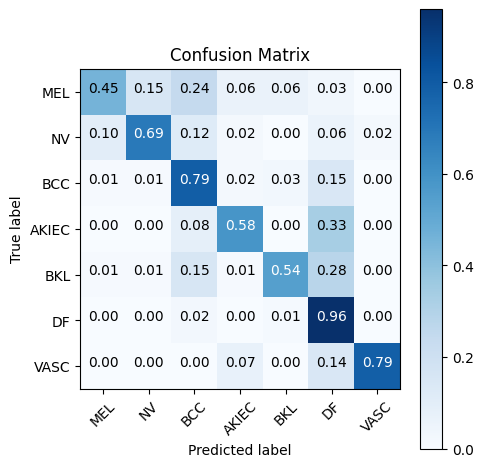

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

ROC-AUC curve

32/32 [==============================] - 5s 160ms/step


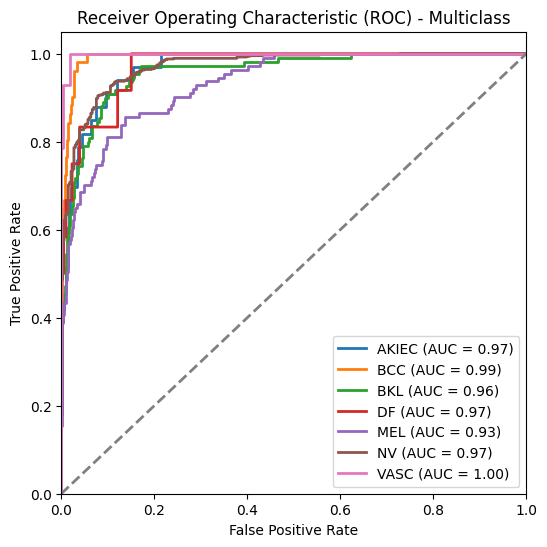

In [ ]:
# Define class names
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Make predictions on the test data
predictions = model.predict(test_data)

# Get the number of classes
num_classes = test_labels.shape[1]

# Initialize a figure to plot ROC curves
plt.figure(figsize=(6, 6))

# Loop through each class
for class_index in range(num_classes):
    # Compute ROC curve and ROC AUC for the current class
    fpr, tpr, thresholds = roc_curve(test_labels[:, class_index], predictions[:, class_index])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for the current class
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[class_index]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random chance)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc='lower right')

# Display the plot
plt.show()


## Misclass Classification

In [ ]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
gpus = [device.name for device in device_list if device.device_type == 'GPU']
print('TensorFlow recognized {} GPUs'.format(len(gpus)))

TensorFlow recognized 1 GPUs


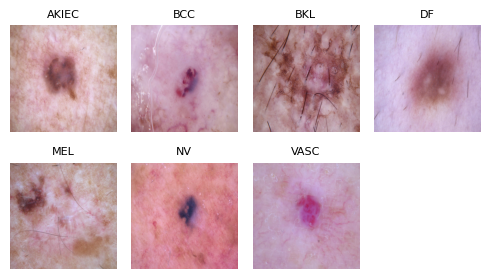

In [ ]:
image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_images = len(image_titles)

# Convert one-hot encoded labels to integer labels
test_labels_int = np.argmax(test_labels, axis=1)
# Find the indices of the first image from each class
class_indices = [np.where(test_labels_int == i)[0][0] for i in range(len(image_titles))]

# Create an array to store the images
image_array = []

# Create subplots with 2 rows
num_rows = 2
num_cols = (num_images + 1) // num_rows
fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols
    ax[row, col].set_title(title, fontsize=8)

    # Display the image from test data
    img = test_data[class_indices[i]]
    image_array.append(img)  # Store the image in the array

    ax[row, col].imshow(img)
    ax[row, col].axis('off')

# Remove any empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

X = base_preprocess(np.array(image_array))

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0, 1, 2, 3, 4, 5, 6])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1][2][3][4][5][6])

Faster Scorecam

3/3 [==============================] - 6s 654ms/step


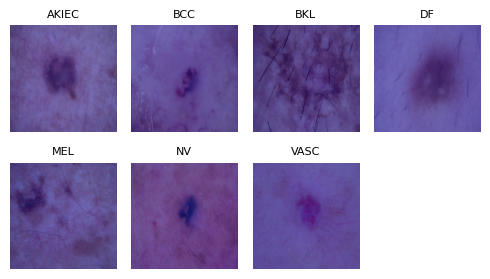

CPU times: user 17.4 s, sys: 351 ms, total: 17.7 s
Wall time: 27.4 s


In [ ]:
%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = (num_images + 1) // num_rows

# Render
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(image_array[i])
    ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[row, col].axis('off')

# Remove any empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

3/3 [==============================] - 19s 1s/step


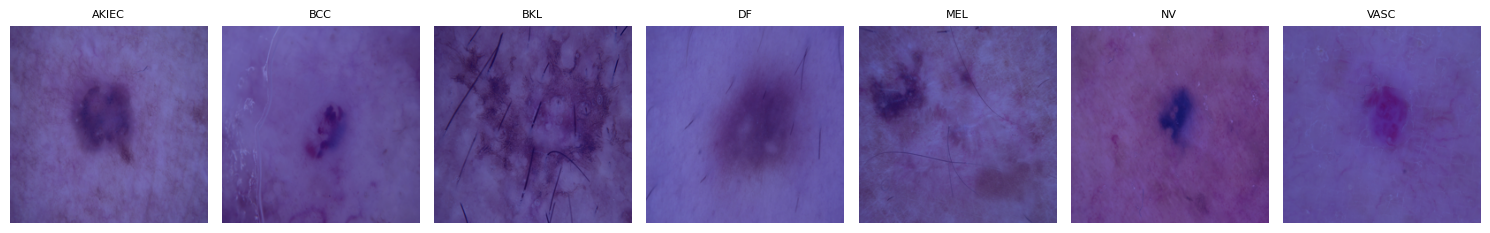

CPU times: user 19.9 s, sys: 1.01 s, total: 20.9 s
Wall time: 40.4 s


In [ ]:
%%time
from matplotlib import pyplot as plt, cm
from tf_keras_vis.scorecam import Scorecam

# Assuming you have already defined model and replace2linear

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmaps with Faster-ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1, max_N=10)

# Calculate the number of images
num_images = len(image_titles)

# Create a single row plot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

    combined_image = cv2.addWeighted(image_array[i], 0.5, heatmap, 0.5, 0)

    axes[i].set_title(title, fontsize=8)
    axes[i].imshow(combined_image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

SmoothGrad

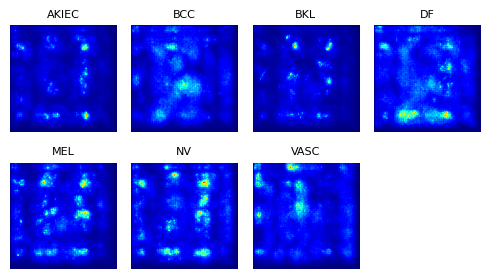

CPU times: user 25.5 s, sys: 545 ms, total: 26 s
Wall time: 29.3 s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = (num_images + 1) // num_rows

# Render
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(saliency_map[i], cmap='jet')
    ax[row, col].axis('off')

# Remove any empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

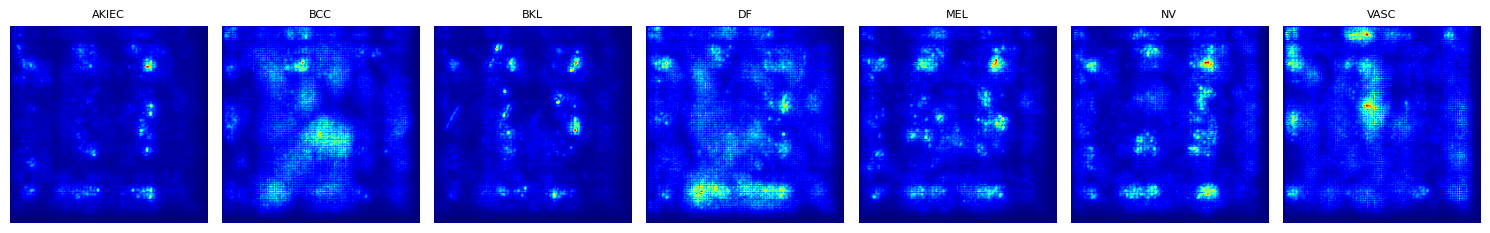

CPU times: user 29.8 s, sys: 754 ms, total: 30.6 s
Wall time: 50.3 s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Create Saliency object.
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# Generate saliency maps with smoothing that reduces noise by adding noise
saliency_maps = saliency(score, X, smooth_samples=20, smooth_noise=0.20)

# Calculate the number of images
num_images = len(image_titles)

# Create a single row plot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    axes[i].set_title(title, fontsize=8)
    axes[i].imshow(saliency_maps[i], cmap='jet')
    axes[i].axis('off')

plt.tight_layout()
plt.show()